### import packages

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn
from data_generator_glad import *
import pickle as pkl
print("import package finished.")

2.3
import package finished.


### hyperparameters

In [2]:
K_train = 10 # 10
M = 100
N = 100 # number of features
graph_type = "random_maxd"
SAMPLE_BATCHES = 10
w_min = -1
w_max = 1
SIGNS = 0
K_test = 100 # 100
prob = 0.1
MAX_DEG = 50
K_valid = 10
data_path = "./data/syn/Ktrain{}_Ktest{}_M{}_N{}_prob{}.pkl".format(K_train, K_test, M, N, prob)

### data generators

In [3]:
def prepare_data_helper(graphs):
    theta, s = [], [] # precision_mat, samples covariance mat
    for g_num in graphs:
        precision_mat, data = graphs[g_num] # data = M x N
        theta.append(precision_mat)
        s.append(np.matmul(data.T, data)/(M))
        # check whether the diagonals are all positive
        if np.all(s[-1].diagonal() > 0) == False:
            print('Diagonals of emp cov matrix are negative: CHECK', s, s[-1].diagonal())
#        else:
#            print('Diagonals of emp cov matrix are positive:', s[-1].diagonal())

    theta = np.array(theta)
    s     = np.array(s)

    # plt.figure()
    # seaborn.heatmap(theta[0], cmap="pink_r", vmax=1)
    # plt.show()

    return [theta, s]

def prepare_data(mn):
    train_data = prepare_data_helper(mn.train_graphs)
    valid_data = []
    if K_valid > 0:
        valid_data = prepare_data_helper(mn.valid_graphs)
    test_data  = prepare_data_helper(mn.test_graphs)
    return train_data, valid_data, test_data

### generate data

In [4]:
if not os.path.exists(data_path):
    print("Generating data...")
    mn = create_MN_vary_w(K_train, M, N, graph_type, SAMPLE_BATCHES, [w_min, w_max], K_test, [prob, MAX_DEG, SIGNS], K_valid)
    train_data, valid_data, test_data = prepare_data(mn)
    print("Data generation finished.")

    with open(data_path, 'wb') as f:
        pkl.dump({"train_data":train_data, "valid_data":valid_data, "test_data":test_data}, f)

else:
    with open(data_path, 'rb') as f:
        data = pkl.load(f)
        train_data, valid_data, test_data = data['train_data'], data['valid_data'], data['test_data']
print("data load finished.")

data load finished.


## model training

### import packages

In [5]:
from unrolled_model import *
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ExponentialLR, ReduceLROnPlateau
import random
import metrics
print("import training needed packages")

import training needed packages


### training parameters

In [6]:
TRAIN = True
USE_CUDA = True
L = 30
rho_init = 1
lambda_init = 1
theta_init_offset = 1e-2
gamma_init = 0.1
nF = 3
H = 3
init_lr = 0.001
use_optimizer = 'adam'
batch_size = 1
train_epochs = 10
INIT_DIAG = 0
lossBCE = 0
loss_signed = 0
lossL1 = 0
model_path = "M{}_N{}_Ktrain{}_gt{}_prob{}_bs{}_L{}_lr{}.pth".format(M, N, K_train, graph_type, prob, batch_size, L, init_lr)

### train validate function

In [7]:
def train_glasso(data, valid_data=[]):  # tied lista
    #    torch.set_grad_enabled(True)
    print('training GLASSO')
    theta, S = data
    #    theta = theta[0]
    if len(valid_data) > 0:
        valid_theta, valid_S = valid_data
        valid_theta_true = convert_to_torch(valid_theta, TESTING_FLAG=True, USE_CUDA=USE_CUDA)
        valid_S = convert_to_torch(valid_S, TESTING_FLAG=True, USE_CUDA=USE_CUDA)
    # theta -> K_train x N x N (Matrix)
    # S -> K_train x N x N (observed vector)
    # train using ALISTA style training.
    # model = threshold_NN_lambda_single_model(L, rho_init, lambda_init, theta_init_offset, gamma_init, N, nF, H, USE_CUDA=USE_CUDA)
    model = threshold_NN_lambda_unrolled_model(L, rho_init, lambda_init, theta_init_offset, gamma_init, N, nF, H, USE_CUDA=USE_CUDA)

    model.train()
    theta_true = convert_to_torch(theta, TESTING_FLAG=True, USE_CUDA=USE_CUDA)
    S = convert_to_torch(S, TESTING_FLAG=True, USE_CUDA=USE_CUDA)

    zero = torch.Tensor([0])  # .type(self.dtype)

    #    print('check: theta ', theta_init.shape)
    #    print('true: ', theta_true)
    print('parameters to be learned')
    for name, param in model.named_parameters():
        print(name, param.shape, param.requires_grad)
    dtype = torch.FloatTensor
    if USE_CUDA:
        model = model.cuda()
        zero = zero.cuda()
        dtype = torch.cuda.FloatTensor

    lr = init_lr
    if use_optimizer == 'adadelta':
        optimizer = torch.optim.Adadelta(model.parameters(), lr=lr, rho=0.9, eps=1e-06,
                                         weight_decay=0)  # LR range = 5 ->
    elif use_optimizer == 'rms':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.25,
                                        centered=False)
    elif use_optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, dampening=0, weight_decay=0,
                                    nesterov=False)
    elif use_optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    else:
        print('Optimizer not found!')
    # scheduler = MultiStepLR(optimizer, milestones=[1000], gamma=0.5)
    scheduler = MultiStepLR(optimizer, milestones=[10, 15, 20, 25, 100, 200], gamma=0.25)
    # scheduler = MultiStepLR(optimizer, milestones=[10, 15, 20, 100, 200], gamma=0.25)
    # scheduler = MultiStepLR(optimizer, milestones=[10, 20, 30, 200], gamma=0.5)
    # criterion = nn.MSELoss(reduction="sum")  # input, target
    criterion = nn.MSELoss()  # input, target
    criterion_L1 = nn.L1Loss()
    m_sig = nn.Sigmoid()
    criterionBCE = nn.BCELoss()

    # batch size is fixed
    #    num_batches = int(args.K_train/args.batch_size)
    #    if args.SAMPLE_BATCHES > 0:
    #        num_batches = int(args.K_train*args.SAMPLE_BATCHES/args.batch_size)

    num_batches = int(len(S) / batch_size)

    #    if args.K_train >= 10:
    #        args.batch_size = 10
    # best_shd_model = model
    best_valid_shd, best_valid_ps, best_valid_nmse = np.inf, -1 * np.inf, np.inf
    EARLY_STOP = False
    for epoch in range(train_epochs):  # 1 epoch is expected to go through complete data
        scheduler.step()
        #        if epoch%1==0:
        #            for param_group in optimizer.param_groups:
        #                print('epoch: ', epoch, ' lr ', param_group['lr'])
        epoch_loss = []
        frob_loss = []
        duality_gap = []
        mse_binary_loss = []
        bce_loss = []
        if EARLY_STOP:
            break
        #        print('ecpohc ', epoch)
        for batch_num in range(num_batches):  # processing batchwise
            optimizer.zero_grad()
            # resetting the loss to zero
            loss = torch.Tensor([0]).type(dtype)
            # Get a batch
            # ridx = random.sample(list(range(args.K_train)), args.batch_size)
            ridx = random.sample(list(range(len(S))), batch_size)
            Sb = S[ridx]  # [0]
            #            print('errr train check : ', batch_num, theta_true, Sb, theta_true.expand_as(Sb))

            if INIT_DIAG == 1:
                # print(' extract batchwise diagonals, add offset and take inverse')
                batch_diags = 1 / (torch.diagonal(Sb, offset=0, dim1=-2, dim2=-1) + model.theta_init_offset)
                theta_init = torch.diag_embed(batch_diags)
            else:
                # print('***************** (S+theta_offset*I)^-1 is used')
                theta_init = torch.inverse(
                    Sb + model.theta_init_offset * torch.eye(Sb.shape[-1]).expand_as(Sb).type_as(Sb))


            # theta_pred = S_inv[r_idx]
            # ll = torch.cholesky(theta_init[ridx])#(theta_pred) # lower triangular
            # ll = my_cholesky(theta_init[ridx][0])#(theta_pred) # lower triangular
            # ll = batch_cholesky(theta_init[ridx])#(theta_pred) # lower triangular
            theta_pred = theta_init  # [ridx]
            # theta_pred = theta_init[ridx]
            # theta_pred.requires_grad = True
            # Sb = S[ridx][0]
            # step_size = get_init_step_size(theta_init[ridx])
            identity_mat = torch.eye(Sb.shape[-1]).expand_as(Sb)
            if USE_CUDA == True:
                identity_mat = identity_mat.cuda()
            # print('ERRR check: ', theta_pred.shape, get_frobenius_norm(theta_pred), get_frobenius_norm(theta_pred).shape)
            # lambda_k = model.lambda_f(get_frobenius_norm(theta_pred))
            lambda_k = model.lambda_forward(zero + lambda_init, zero, k=0)
            for k in range(L):
                #                print('itr = ', itr, theta_pred)#, theta_true[ridx])
                # step 1 : AM
                b = 1.0 / lambda_k * Sb - theta_pred
                b2_4ac = torch.matmul(b.transpose(-1, -2), b) + 4.0 / lambda_k * identity_mat
                sqrt_term = batch_matrix_sqrt(b2_4ac)
                theta_k1 = 1.0 / 2 * (-1 * b + sqrt_term)
                """
                # extract the diagonals of the matrices
                theta_diag = torch.diag_embed(torch.diagonal(theta_k1, offset=0, dim1=-2, dim2=-1))
                # soft threshold on remaining entries 
                theta_pred = model.eta_forward(theta_k1-theta_diag, k)
                # add the diagonals
                theta_pred = theta_pred + theta_diag
                """
                # softthresholding on all the entries
                # theta_pred = model.eta_forward(theta_k1, k)

                # if MODEL_type == 'th':
                #     # soft thresholding + eigenvalue correctness term
                #     theta_pred = model.eta_forward(theta_k1, k) + torch.max(model.gamma_c[k],
                #                                                             zero + 1e-2) * identity_mat
                # elif MODEL_type == 'th_NN':
                theta_pred = model.eta_forward(theta_k1, Sb, k, theta_pred)  #
                # update the lambda
                lambda_k = model.lambda_forward(torch.Tensor([get_frobenius_norm(theta_pred - theta_k1)]).type(dtype),
                                                lambda_k, k)
                # accumulating loss
                #                print('k= ', k, ' lambda_value ', lambda_k, get_frobenius_norm(theta_pred-theta_k1))

                loss += criterion(theta_pred, theta_true[ridx]) / L
                # loss += criterion(theta_pred, theta_true.expand_as(theta_pred))/args.L

            #            print('k= ', k, ' lambda_value ', lambda_k)
            # print('thetapred: ', theta_pred, check_sym(theta_pred[0].data.cpu().numpy()))
            # delta = batch_duality_gap(theta_pred, Sb, model.rho)
            # NOTE: ******* IMP: Change thissss!@!! ****************************
            delta = torch.ones([1]) * -1

            loss += criterion(theta_pred, theta_true[ridx]) / L

            # loss += criterion(theta_pred, theta_true.expand_as(theta_pred))/args.L

            lossf = get_frobenius_norm(theta_pred - theta_true[ridx])
            # total_loss = loss #+ delta
            # total_loss = lossB #+ loss #+ delta
            # total_loss = loss + lossB+ delta + lossBCE
            #            total_loss = lossBCE
            # total_loss = delta
            if lossBCE == 1:  # binary cross entropy
                total_loss = lossBCE
            elif loss_signed == 1:  # signed loss
                # total_loss = criterion(torch.sign(theta_pred), torch.sign(theta_true.expand_as(theta_pred)))
                total_loss = criterion(theta_pred, torch.sign(theta_true.expand_as(theta_pred)))
            elif lossL1 == 1:  # signed loss
                total_loss = criterion_L1(theta_pred, theta_true.expand_as(theta_pred))
            else:  # frobenius norm
                total_loss = loss
                # total_loss = lossf
            #            total_loss.requires_grad = True
            #            print('err: ', total_loss, total_loss.requires_grad)

            lv = loss.data.cpu().numpy()
            if lv <= 1e-7:  # loss value
                print('Early stopping as loss = ', lv)
                EARLY_STOP = True
                break

            total_loss.backward()
            # delta.backward()

            #            for name, param in model.named_parameters():
            #                print('befoer: ', name, param)
            optimizer.step()

            #            for name, param in model.named_parameters():
            #                print('after: ', name, param)

            #            mse_binary_loss.append(lossB.data.cpu().numpy())
            #            bce_loss.append(lossBCE.data.cpu().numpy())
            #            duality_gap.append(delta.data.cpu().numpy())
            frob_loss.append(lossf.data.cpu().numpy())
            epoch_loss.append(loss.data.cpu().numpy())
        if epoch % 2 == 0 and EARLY_STOP == False:
            # print(len(epoch_loss))
            # print('loss_summary: MSE: ', sum(epoch_loss)/len(epoch_loss), ' Mean Frobenius loss: ',sum(frob_loss)/len(frob_loss), ' MSE_binary loss: ', sum(mse_binary_loss)/len(mse_binary_loss), 'BCE_loss: ', sum(bce_loss)/len(bce_loss), 'duality gap = ', sum(duality_gap)/len(duality_gap))
            print('loss_summary: MSE: ', sum(epoch_loss)/len(epoch_loss), ' Mean Frobenius loss: ',sum(frob_loss)/len(frob_loss))
            if lossBCE == 1:
                print(epoch, sum(epoch_loss) / len(epoch_loss), sum(bce_loss) / len(bce_loss))
            else:
                print('loss_values: ', epoch, sum(epoch_loss) / len(epoch_loss))  # , sum(duality_gap)/len(duality_gap))
        # Checking the results on valid data and updating the best model
        if len(valid_data) > 0:
            # get the SHD on the valid data and the train data
            # curr_valid_shd, curr_valid_nmse = glasso_predict(model, valid_data)
            curr_valid_shd, curr_valid_ps, curr_valid_nmse, curr_valid_gmse, curr_valid_gmse_ediag = glasso_predict(model, valid_data)
            curr_train_shd, curr_train_ps, curr_train_nmse, curr_valid_gmse, curr_valid_gmse_ediag = glasso_predict(model, data)
            print('valid/train: shd %0.2f/%0.2f ps %0.2f/%0.2f nmse %0.2f/%0.2f' % (
            curr_valid_shd, curr_train_shd, curr_valid_ps, curr_train_ps, curr_valid_nmse, curr_train_nmse))
            #            if curr_valid_shd <= best_valid_shd:
            if curr_valid_ps >= best_valid_ps:
                print('epoch = ', epoch, ' Updating the best ps model with valid ps = ', curr_valid_ps)
                best_ps_model = copy.deepcopy(model)
                best_valid_ps = curr_valid_ps

            if curr_valid_shd <= best_valid_shd:
                print('epoch = ', epoch, ' Updating the best shd model with valid shd = ', curr_valid_shd)
                best_shd_model = copy.deepcopy(model)
                best_valid_shd = curr_valid_shd

            if curr_valid_nmse <= best_valid_nmse:
                print('epoch = ', epoch, ' Updating the best nmse model with valid nmse = ', curr_valid_nmse)
                best_nmse_model = copy.deepcopy(model)
                best_valid_nmse = curr_valid_nmse
                print('epoch = ', epoch, ' Updating the best nmse model with valid gmse = ', curr_valid_gmse)
                print('epoch = ', epoch, ' Updating the best nmse model with valid gmse except diag = ', curr_valid_gmse_ediag)
            model.train()
            print('loss_summary:: epoch: ', epoch, ' loss: ', sum(epoch_loss)/len(epoch_loss))#, ' NMSE loss: ', 10*np.log10( (np.sum(np.array(epoch_loss)))/(len(epoch_loss)*E_norm_xtrue)))
    #    print('ans: ', theta_pred)
    #    print('true: ', theta_true)
    for name, param in model.named_parameters():
        print(name, param)
    # return best_ps_model # model
    return best_nmse_model, best_shd_model, best_ps_model  # model

### predict function

In [8]:
def glasso_predict(model, data, flagP=False, SAVE_GRAPH=False, eM=0, name='', mn=''):
    with torch.no_grad():
        print('Running unrolled ADMM predict')
        # predict as a complete batch?
        model.eval()
        criterion = nn.MSELoss()  # input, target
        m_sig = nn.Sigmoid()
        criterionBCE = nn.BCELoss()
        theta, S = data
        #    theta = theta[0]
        # theta -> K_train x N x N (Matrix)
        # S -> K_train x N x N (observed vector)
        # theta_true = convert_to_torch(theta, TESTING_FLAG=True, USE_CUDA=False)
        theta_true = convert_to_torch(theta, TESTING_FLAG=True, USE_CUDA=USE_CUDA)
        S = convert_to_torch(S, TESTING_FLAG=True, USE_CUDA=USE_CUDA)

        zero = torch.Tensor([0])  # .type(self.dtype)
        dtype = torch.FloatTensor
        if USE_CUDA == True:
            zero = zero.cuda()
            model = model.cuda()
            dtype = torch.cuda.FloatTensor

        # batch size is fixed for testing as 1
        batch_size = 1
        print('CEHCKK: Total graphs = ', len(S))
        num_batches = int(len(S) / batch_size)
        #    print('num batches: ', num_batches)
        epoch_loss = []
        mse_binary_loss = []
        bce_loss = []
        frob_loss = []
        duality_gap = []
        ans = []
        if flagP:
            res_conv = {}
            for k in range(L + 1):
                res_conv[k] = []
        #        print('ITR, conv.loss, obj_val_pred, obj_val_true_model_rho, obj_val_pred_args_rho')#, theta_pred)

        res = []
        for batch_num in range(num_batches):  # processing batchwise
            # Get a batch
            # ll = my_cholesky(theta_init[ridx][0])#(theta_pred) # lower triangular
            # theta_pred = theta_init[batch_num*batch_size: (batch_num+1)*batch_size] #(theta_pred) # lower triangular
            # theta_true_b = theta_true[batch_num*batch_size: (batch_num+1)*batch_size]
            theta_true_b = theta_true[batch_num * batch_size: (batch_num + 1) * batch_size]
            Sb = S[batch_num * batch_size: (batch_num + 1) * batch_size]  # [0]
            identity_mat = torch.eye(Sb.shape[-1]).expand_as(Sb)
            if USE_CUDA == True:
                identity_mat = identity_mat.cuda()
                Sb = Sb.cuda()
            #    theta_pred = theta_pred.cuda()
            #    theta_true_b = theta_true_b.cuda()

            if INIT_DIAG == 1:
                # print(' extract batchwise diagonals, add offset and take inverse')
                batch_diags = 1 / (torch.diagonal(Sb, offset=0, dim1=-2, dim2=-1) + model.theta_init_offset)
                theta_pred = torch.diag_embed(batch_diags)
            else:
                # print('***************** (S+theta_offset*I)^-1 is used')
                theta_pred = torch.inverse(
                    Sb + model.theta_init_offset * torch.eye(Sb.shape[-1]).expand_as(Sb).type_as(Sb))

            # lambda_k = model.lambda_f(get_frobenius_norm(theta_pred))
            lambda_k = model.lambda_forward(zero + lambda_init, zero, k=0)

            #        if flagP:
            #            print('ITR, conv.loss, obj_val_pred, obj_val_true_model_rho, obj_val_pred_args_rho')#, theta_pred)
            for k in range(L):
                #            start = time.time()
                if flagP:
                    theta_pred_diag = torch.diag_embed(torch.diagonal(theta_pred[0], offset=0, dim1=-2, dim2=-1))
                    # theta_true_b_diag = torch.diag_embed(torch.diagonal(theta_true_b[0], offset=0, dim1=-2, dim2=-1))
                    theta_true_b_diag = torch.diag_embed(torch.diagonal(theta_true_b, offset=0, dim1=-2, dim2=-1))
                    # if MODEL_type == 'th':
                    #     cv_loss, cv_loss_off_diag, obj_pred, obj_true_rho, obj_true_orig = get_convergence_loss(
                    #         theta_pred[0], theta_true_b), get_convergence_loss(theta_pred[0] - theta_pred_diag,
                    #                                                            theta_true_b - theta_true_b_diag), get_obj_val(
                    #         theta_pred[0], Sb[0], model.rho_l1[k]), get_obj_val(theta_true_b, Sb[0],
                    #                                                             model.rho_l1[k]), get_obj_val(
                    #         theta_true_b, Sb[0], rho_init)
                    #     res_conv[k].append([cv_loss, obj_pred, obj_true_rho, obj_true_orig, cv_loss_off_diag])
                    # elif MODEL_type == 'th_NN':
                    cv_loss, cv_loss_off_diag = get_convergence_loss(theta_pred[0],
                                                                         theta_true_b), -1  # get_convergence_loss(theta_pred[0]-theta_pred_diag, theta_true_b-theta_true_b_diag)
                    res_conv[k].append([cv_loss, cv_loss_off_diag])
                # step 1 : AM
                b = 1.0 / lambda_k * Sb - theta_pred
                b2_4ac = torch.matmul(b.transpose(-1, -2), b) + 4.0 / lambda_k * identity_mat
                sqrt_term = batch_matrix_sqrt(b2_4ac)
                theta_k1 = 1.0 / 2 * (-1 * b + sqrt_term)

                # step 2 : AM
                """ 
                # extract the diagonals of the matrices
                theta_diag = torch.diag_embed(torch.diagonal(theta_k1, offset=0, dim1=-2, dim2=-1))
                # soft threshold on remaining entries 
                theta_pred = model.eta_forward(theta_k1-theta_diag, k)
                # add the diagonals
                theta_pred = theta_pred + theta_diag
                """
                # soft thresholding on all the entries
                # theta_pred = model.eta_forward(theta_k1, k)
                # if MODEL_type == 'th':
                #     # soft thresholding + eigenvalue correctness term
                #     theta_pred = model.eta_forward(theta_k1, k) + torch.max(model.gamma_c[k],
                #                                                             zero + 1e-2) * identity_mat
                # elif MODEL_type == 'th_NN':
                    # theta_pred = model.eta_forward(theta_k1, Sb, k) + torch.max(model.gamma_c[k], zero+1e-2) * identity_mat
                    # theta_pred = model.eta_forward(theta_k1, Sb, k, theta_pred) + torch.max(model.gamma_c[k], zero+1e-2) * identity_mat
                theta_pred = model.eta_forward(theta_k1, Sb, k,
                                                   theta_pred)  # + torch.max(model.gamma_c[k], zero+1e-2) * identity_mat

                # updating lambda
                lambda_k = model.lambda_forward(torch.Tensor([get_frobenius_norm(theta_pred - theta_k1)]).type(dtype),
                                                lambda_k, k)
                # lambda_k = model.lambda_f(get_frobenius_norm(theta_pred-theta_k1))
            #            print('k= ', k, ' lambda_value ', lambda_k, get_frobenius_norm(theta_pred-theta_k1))
            #            stop = time.time()
            #            print('Walltimes: ', k, stop-start)
            #        br
            if flagP:
                theta_pred_diag = torch.diag_embed(torch.diagonal(theta_pred[0], offset=0, dim1=-2, dim2=-1))
                # Getting the final predicted convergence loss
                if torch.min(torch.eig(theta_pred[0])[0][:, 0]) == 0:
                    adjust_eval_identity = torch.eye(theta_pred.shape[-1]).expand_as(theta_pred[0]).type_as(
                        theta_pred[0])
                    print('Adjusting the minimum eigenvalue to 1, SHOULD NOT BE CALLED AFTER THE GAMMA ADDITION!')
                    theta_pred[0] += adjust_eval_identity  # change the eigenval to 1
                # if MODEL_type == 'th':
                #     cv_loss, cv_loss_off_diag, obj_pred, obj_true_rho, obj_true_orig = get_convergence_loss(
                #         theta_pred[0], theta_true_b), get_convergence_loss(theta_pred[0] - theta_pred_diag,
                #                                                            theta_true_b - theta_true_b_diag), get_obj_val(
                #         theta_pred[0], Sb[0], model.rho_l1[k]), get_obj_val(theta_true_b, Sb[0],
                #                                                             model.rho_l1[k]), get_obj_val(theta_true_b,
                #                                                                                           Sb[0],
                #                                                                                           args.rho_init)
                #     res_conv[k + 1].append([cv_loss, obj_pred, obj_true_rho, obj_true_orig, cv_loss_off_diag])
                # elif MODEL_type == 'th_NN':
                cv_loss, cv_loss_off_diag = get_convergence_loss(theta_pred[0],
                                                                     theta_true_b), -1  # get_convergence_loss(theta_pred[0]-theta_pred_diag, theta_true_b-theta_true_b_diag)
                res_conv[k + 1].append([cv_loss, cv_loss_off_diag])
            
            if Plot:
                print("=====================")

                plt.figure()
                seaborn.heatmap(theta_pred[0][:10,:10].cpu().detach().numpy(),cmap="pink_r",vmax=1)
                plt.show()

                plt.figure()
                seaborn.heatmap(theta_true_b[0][:10,:10].cpu().detach().numpy(),cmap="pink_r",vmax=1)
                plt.show()

            final_nmse, final_gmse, n, d, final_gmse_exp_diag, n1, d1 = get_convergence_loss(theta_pred[0], theta_true_b)
            theta_pred = theta_pred[0].data.cpu().numpy()
            #        theta_true_b = theta_true_b[0].data.cpu().numpy()
            theta_true_b = theta_true_b.data.cpu().numpy()

            fdr, tpr, fpr, shd, nnz, nnz_true, ps = metrics.report_metrics(theta_true_b, theta_pred)
            cond_theta_pred, cond_theta_true_b = np.linalg.cond(theta_pred), -1  # np.linalg.cond(theta_true_b)
            res.append([fdr, tpr, fpr, shd, nnz, nnz_true, ps, cond_theta_pred, cond_theta_true_b])

        res_mean = np.mean(np.array(res), 0)
        res_std = np.std(np.array(res), 0)
        res_mean = ["%.3f" % x for x in res_mean]
        res_std = ["%.3f" % x for x in res_std]

        if flagP:
            print('Structure learning Metrics')
            print('Average result over test graphs')
            # print('fdr, tpr, fpr, shd, nnz, nnz_true, np.linalg.cond(theta_pred), np.linalg.cond(theta_true)')
            print('fdr, tpr, fpr, shd, nnz, nnz_true, ps, np.linalg.cond(theta_pred), np.linalg.cond(theta_true)')
            print(*sum(list(map(list, zip(res_mean, res_std))), []), sep=', ')

            # print('ITR, conv.loss, obj_val_pred, obj_val_true_model_rho, obj_val_pred_args_rho')#, theta_pred)
#             print(
#                 'ITR, conv_loss"ecoli_M"+str(eM), obj_val_pred, obj_val_true_model_rho, obj_val_pred_args_rho, conv_loss_off_diag')  # , theta_pred)
#             for i in res_conv:
#                 mean_vec = ["%.3f" % x for x in np.mean(np.array(res_conv[i].cpu().detach()), 0)]
#                 std_vec = ["%.3f" % x for x in np.std(np.array(res_conv[i].cpu().detach()), 0)]
#                 print(i, *sum(list(map(list, zip(mean_vec, std_vec))), []), sep=', ')
        #            print(i, np.mean(res_conv[i], 0), np.std(res_conv[i], 0))

        if SAVE_GRAPH:
            x = np.where(theta_pred > 0, 1, 0)
            A = np.matrix(x - np.eye(x.shape[0]))
            G = nx.from_numpy_matrix(A)
            fig = plt.figure(figsize=(15, 15))
            mapping = {n1: n2 for n1, n2 in zip(G.nodes(), mn.nodes)}
            G = nx.relabel_nodes(G, mapping)
            # nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels = True)
            # nx.draw_networkx(G, pos=nx.circular_layout(G), with_labels = True)
            nx.draw_networkx(G, pos=nx.shell_layout(G), with_labels=True)
            plt.savefig(name + '_' + str(eM) + ".pdf", bbox_inches='tight')
            nx.draw_networkx(mn.G_true, pos=nx.shell_layout(G), with_labels=True)
            plt.savefig(name + '_true_' + str(eM) + ".pdf", bbox_inches='tight')
            # saving the graph
            # nx.write_gpickle(G, name+'_'+str(eM)+'.gpickle')
            nx.write_adjlist(G, name + '_' + str(eM) + '.adjlist')

        return np.float(res_mean[3]), np.float(res_mean[6]), final_nmse, final_gmse, final_gmse_exp_diag  # The PS mean value, final NMSE obtained

### training process

In [9]:
Plot = False
if TRAIN == True:
    print('Training the glasso model')
    print('check: ', train_data[0].shape, train_data[1].shape)
    nmse_model, shd_model, ps_model = train_glasso(train_data, valid_data)

model = nmse_model  # shd_model # or nmse_model

torch.save(nmse_model.state_dict(), model_path)

print('TIMING check:')
glasso_predict(model, train_data)

Training the glasso model
check:  (100, 100, 100) (100, 100, 100)
training GLASSO
shifting to cuda
CHECK RHO INITIAL:  Parameter containing:
tensor([[ 0.5367, -0.1630, -0.5369],
        [-0.3791, -0.1180,  0.4861],
        [-0.4350, -0.2615,  0.2069]], device='cuda:0', requires_grad=True)
parameters to be learned
theta_init_offset torch.Size([1]) True
rho_l1.0.0.weight torch.Size([3, 3]) True
rho_l1.0.0.bias torch.Size([3]) True
rho_l1.0.2.weight torch.Size([3, 3]) True
rho_l1.0.2.bias torch.Size([3]) True
rho_l1.0.4.weight torch.Size([3, 3]) True
rho_l1.0.4.bias torch.Size([3]) True
rho_l1.0.6.weight torch.Size([3, 3]) True
rho_l1.0.6.bias torch.Size([3]) True
rho_l1.0.8.weight torch.Size([3, 3]) True
rho_l1.0.8.bias torch.Size([3]) True
rho_l1.0.10.weight torch.Size([1, 3]) True
rho_l1.0.10.bias torch.Size([1]) True
rho_l1.1.0.weight torch.Size([3, 3]) True
rho_l1.1.0.bias torch.Size([3]) True
rho_l1.1.2.weight torch.Size([3, 3]) True
rho_l1.1.2.bias torch.Size([3]) True
rho_l1.1.4.w

loss_summary: MSE:  [0.13129069]  Mean Frobenius loss:  624.0006088256836
loss_values:  0 [0.13129069]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 496.20/490.00 ps 0.00/0.00 nmse -4.65/-4.71
epoch =  0  Updating the best ps model with valid ps =  0.0
epoch =  0  Updating the best shd model with valid shd =  496.2
epoch =  0  Updating the best nmse model with valid nmse =  -4.65228796005249
epoch =  0  Updating the best nmse model with valid gmse =  0.33768502
epoch =  0  Updating the best nmse model with valid gmse except diag =  1.0
loss_summary:: epoch:  0  loss:  [0.13129069]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 494.29/488.08 ps 0.00/0.00 nmse -6.80/-6.97
epoch =  1  Updating the best ps model with valid ps =  0.0
epoch =  1  Updating the best shd model with valid shd =  494.29
epoch =  1  Updating the best nmse model with valid nmse =  -6.795943379402161
epoch =  1  Updating the best nmse model with valid gmse =  0.20102634
epoch =  1  Updating the best nmse model with valid gmse except diag =  1.0
loss_summary:: epoch:  1  loss:  [0.04917716]
loss_summary: MSE:  [0.03212087]  Mean Frobenius loss:  238.4368460083008
loss_values:  2 [0.03212087]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 500.29/496.71 ps 0.00/0.00 nmse -8.71/-9.15
epoch =  2  Updating the best ps model with valid ps =  0.0
epoch =  2  Updating the best nmse model with valid nmse =  -8.71371328830719
epoch =  2  Updating the best nmse model with valid gmse =  0.12168103
epoch =  2  Updating the best nmse model with valid gmse except diag =  0.8763109
loss_summary:: epoch:  2  loss:  [0.03212087]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 813.97/819.77 ps 0.00/0.00 nmse -9.72/-10.31
epoch =  3  Updating the best ps model with valid ps =  0.0
epoch =  3  Updating the best nmse model with valid nmse =  -9.72233533859253
epoch =  3  Updating the best nmse model with valid gmse =  0.09306517
epoch =  3  Updating the best nmse model with valid gmse except diag =  0.7623909
loss_summary:: epoch:  3  loss:  [0.02456765]
loss_summary: MSE:  [0.02227925]  Mean Frobenius loss:  150.02336059570314
loss_values:  4 [0.02227925]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 943.78/951.41 ps 0.00/0.00 nmse -9.76/-10.36
epoch =  4  Updating the best ps model with valid ps =  0.0
epoch =  4  Updating the best nmse model with valid nmse =  -9.759370684623718
epoch =  4  Updating the best nmse model with valid gmse =  0.092007495
epoch =  4  Updating the best nmse model with valid gmse except diag =  0.763735
loss_summary:: epoch:  4  loss:  [0.02227925]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 929.90/938.61 ps 0.00/0.00 nmse -9.75/-10.35
epoch =  5  Updating the best ps model with valid ps =  0.0
loss_summary:: epoch:  5  loss:  [0.0205836]
loss_summary: MSE:  [0.01949457]  Mean Frobenius loss:  149.24293823242186
loss_values:  6 [0.01949457]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 899.70/907.83 ps 0.00/0.00 nmse -9.75/-10.35
epoch =  6  Updating the best ps model with valid ps =  0.0
loss_summary:: epoch:  6  loss:  [0.01949457]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 862.36/870.15 ps 0.00/0.00 nmse -9.76/-10.36
epoch =  7  Updating the best ps model with valid ps =  0.0
loss_summary:: epoch:  7  loss:  [0.01848471]
loss_summary: MSE:  [0.01821405]  Mean Frobenius loss:  150.45701232910156
loss_values:  8 [0.01821405]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 865.55/873.06 ps 0.00/0.00 nmse -9.74/-10.34
epoch =  8  Updating the best ps model with valid ps =  0.0
loss_summary:: epoch:  8  loss:  [0.01821405]
Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Running unrolled ADMM predict
CEHCKK: Total graphs =  100


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


valid/train: shd 850.58/858.50 ps 0.00/0.00 nmse -9.75/-10.35
epoch =  9  Updating the best ps model with valid ps =  0.0
loss_summary:: epoch:  9  loss:  [0.01758976]
theta_init_offset Parameter containing:
tensor([0.0581], device='cuda:0', requires_grad=True)
rho_l1.0.0.weight Parameter containing:
tensor([[ 0.5448, -0.1528, -0.5287],
        [-0.2966,  0.1138,  0.5679],
        [-0.3646, -0.7131,  0.2781]], device='cuda:0', requires_grad=True)
rho_l1.0.0.bias Parameter containing:
tensor([-0.2809, -0.1964, -0.7662], device='cuda:0', requires_grad=True)
rho_l1.0.2.weight Parameter containing:
tensor([[-0.6103,  0.2897,  0.1751],
        [-0.2254, -0.1244,  0.5606],
        [-0.0872,  0.1389, -0.5039]], device='cuda:0', requires_grad=True)
rho_l1.0.2.bias Parameter containing:
tensor([ 0.4444, -0.1941,  0.1155], device='cuda:0', requires_grad=True)
rho_l1.0.4.weight Parameter containing:
tensor([[-0.7430,  1.0845, -1.1250],
        [ 0.3461, -0.8959, -0.1880],
        [-0.1298,  0.492

rho_l1.17.2.weight Parameter containing:
tensor([[ 0.6076, -0.0082,  0.5738],
        [-0.0960,  0.4777, -0.2959],
        [-0.5246, -0.6829,  0.2191]], device='cuda:0', requires_grad=True)
rho_l1.17.2.bias Parameter containing:
tensor([ 0.5860, -0.2672, -0.5743], device='cuda:0', requires_grad=True)
rho_l1.17.4.weight Parameter containing:
tensor([[-0.7860, -0.3415,  0.1781],
        [-0.1460, -0.3728, -0.5339],
        [-0.6438,  0.3996,  0.6777]], device='cuda:0', requires_grad=True)
rho_l1.17.4.bias Parameter containing:
tensor([-0.0712,  0.6376, -0.5620], device='cuda:0', requires_grad=True)
rho_l1.17.6.weight Parameter containing:
tensor([[ 0.7041,  0.0644, -0.1570],
        [ 0.0779, -0.5842,  0.7295],
        [ 0.4233, -0.5937,  0.5890]], device='cuda:0', requires_grad=True)
rho_l1.17.6.bias Parameter containing:
tensor([-0.0187, -0.0900, -0.3576], device='cuda:0', requires_grad=True)
rho_l1.17.8.weight Parameter containing:
tensor([[-0.1746, -0.1371, -0.6887],
        [ 0.1214

lambda_f.21.2.bias Parameter containing:
tensor([-0.0491, -0.7025,  0.1293], device='cuda:0', requires_grad=True)
lambda_f.21.4.weight Parameter containing:
tensor([[-0.3902, -0.0126, -0.4503],
        [-0.5233,  0.6107,  0.4523],
        [-0.2686, -0.1479, -0.1048]], device='cuda:0', requires_grad=True)
lambda_f.21.4.bias Parameter containing:
tensor([-0.1988,  0.3659, -0.1885], device='cuda:0', requires_grad=True)
lambda_f.21.6.weight Parameter containing:
tensor([[-0.0116,  0.1260,  0.0477]], device='cuda:0', requires_grad=True)
lambda_f.21.6.bias Parameter containing:
tensor([-0.4561], device='cuda:0', requires_grad=True)
lambda_f.22.0.weight Parameter containing:
tensor([[-0.4056,  0.3717],
        [-0.6156, -0.0976],
        [-0.3811, -0.2203]], device='cuda:0', requires_grad=True)
lambda_f.22.0.bias Parameter containing:
tensor([ 0.6305, -0.4920,  0.5493], device='cuda:0', requires_grad=True)
lambda_f.22.2.weight Parameter containing:
tensor([[-0.0695, -0.0860, -0.5161],
       

/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(951.41,
 0.0,
 -10.361768007278442,
 array(0.0920075, dtype=float32),
 array(0.763735, dtype=float32))

### prediction

In [11]:
print('model trained: Predicting on...')
# torch.save(model.state_dict(), 'Gista_model.pt')
print('****Train Data, same pred matrix, different samples****')
#glasso_predict(nmse_model, train_data, True)
res_train = glasso_predict(model, train_data, True)
print(res_train)
# if len(valid_data)>0:
#     print('****Valid Data****')
#     #glasso_predict(nmse_model, valid_data, True)
#     glasso_predict(model, valid_data, True)
print('****Test Data, model_NMSE: average results over different samples****')
res_test_model_NMSE = glasso_predict(model, test_data, True)
print(res_test_model_NMSE)
print('****Test Data, tag: model_SHD : average results over different samples****')
res_test_model_SHD = glasso_predict(ps_model, test_data, True)
print(res_test_model_SHD)

model trained: Predicting on...
****Train Data, same pred matrix, different samples****
Running unrolled ADMM predict
CEHCKK: Total graphs =  100
Structure learning Metrics
Average result over test graphs
fdr, tpr, fpr, shd, nnz, nnz_true, ps, np.linalg.cond(theta_pred), np.linalg.cond(theta_true)
0.695, 0.012, 0.477, 0.021, 0.144, 0.004, 951.410, 24.736, 924.410, 22.087, 590.000, 19.131, 0.000, 0.000, 2.656, 0.164, -1.000, 0.000
(951.41, 0.0, -10.361768007278442, array(0.0920075, dtype=float32), array(0.763735, dtype=float32))
****Test Data, model_NMSE: average results over different samples****
Running unrolled ADMM predict
CEHCKK: Total graphs =  1000


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Structure learning Metrics
Average result over test graphs
fdr, tpr, fpr, shd, nnz, nnz_true, ps, np.linalg.cond(theta_pred), np.linalg.cond(theta_true)
0.695, 0.013, 0.477, 0.021, 0.143, 0.005, 946.508, 25.962, 918.542, 24.285, 588.660, 20.496, 0.000, 0.000, 2.653, 0.164, -1.000, 0.000
(946.508, 0.0, -9.813135862350464, array(0.10439663, dtype=float32), array(0.8158478, dtype=float32))
****Test Data, tag: model_SHD : average results over different samples****
Running unrolled ADMM predict
CEHCKK: Total graphs =  1000


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Structure learning Metrics
Average result over test graphs
fdr, tpr, fpr, shd, nnz, nnz_true, ps, np.linalg.cond(theta_pred), np.linalg.cond(theta_true)
0.666, 0.014, 0.451, 0.021, 0.119, 0.005, 853.651, 25.243, 795.875, 23.157, 588.660, 20.496, 0.000, 0.000, 2.588, 0.158, -1.000, 0.000
(853.651, 0.0, -9.812899827957153, array(0.10440229, dtype=float32), array(0.8178257, dtype=float32))


/home/vanessa/.conda/envs/glad/lib/python3.7/site-packages/ipykernel_launcher.py:203: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### plot

Running unrolled ADMM predict
CEHCKK: Total graphs =  1000


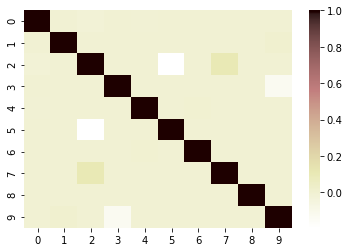

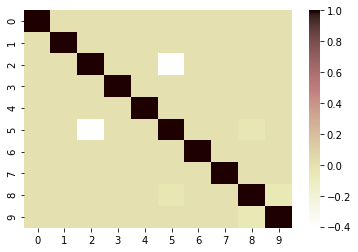

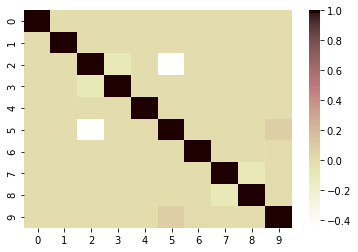

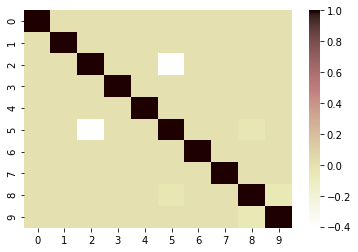

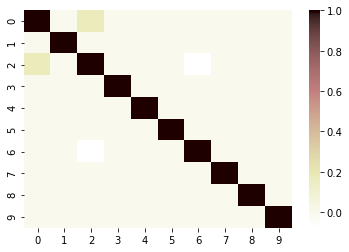

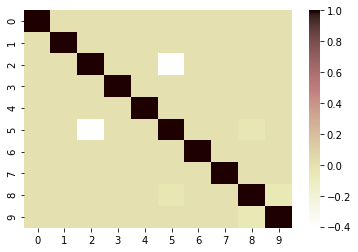

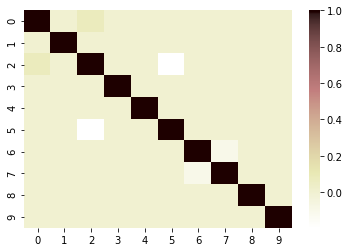

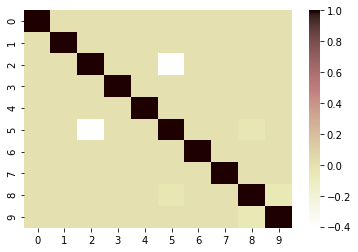

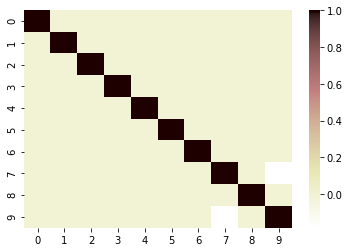

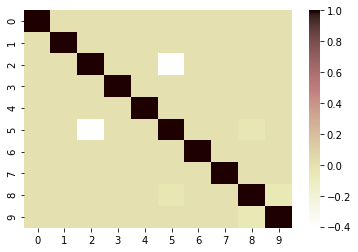

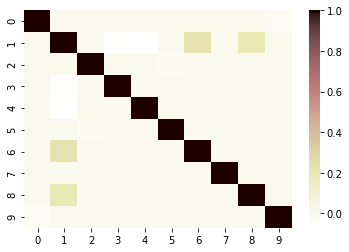

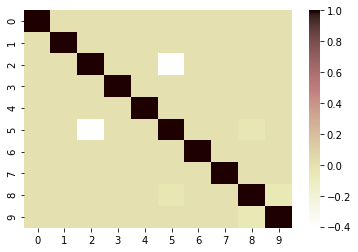

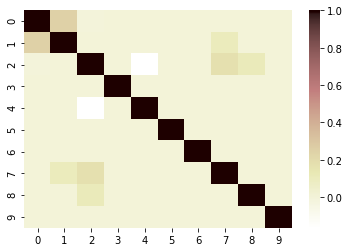

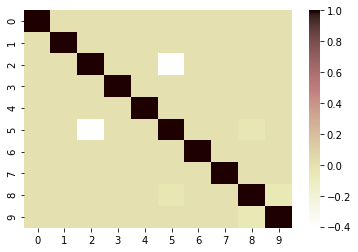

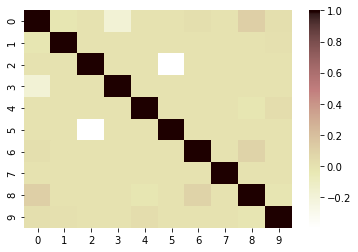

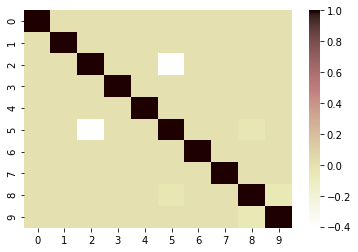

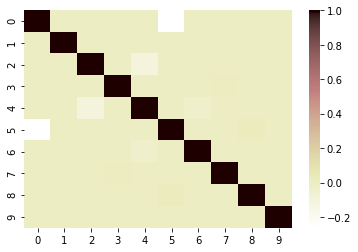

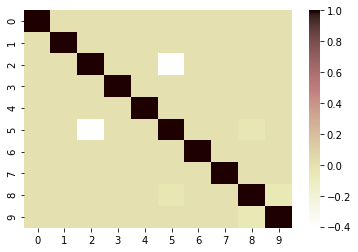

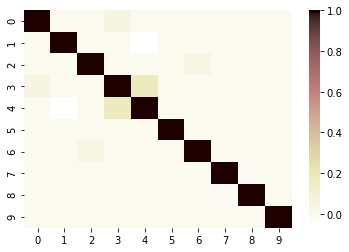

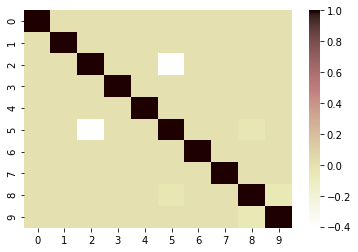

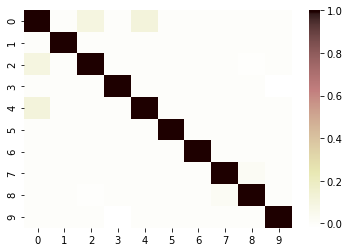

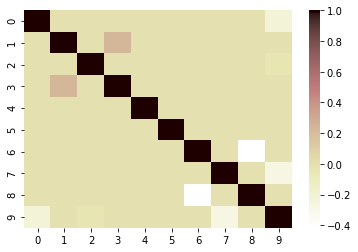

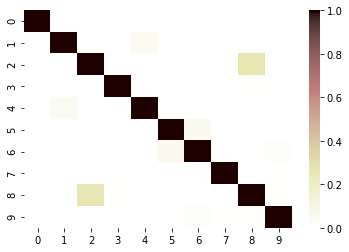

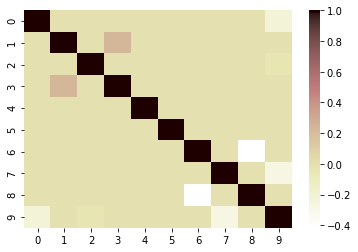

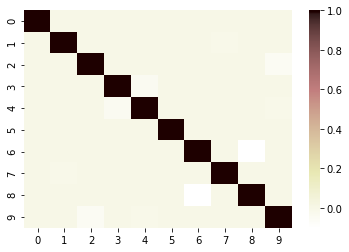

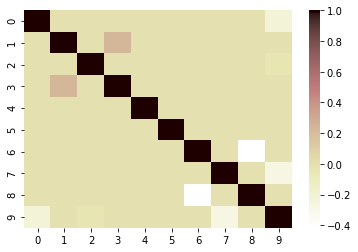

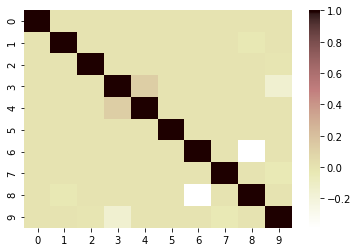

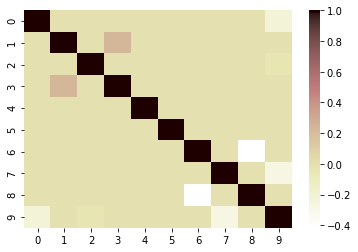

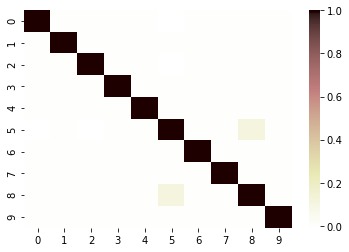

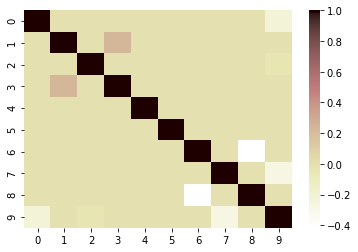

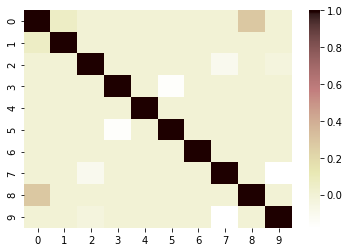

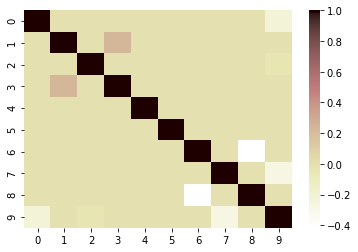

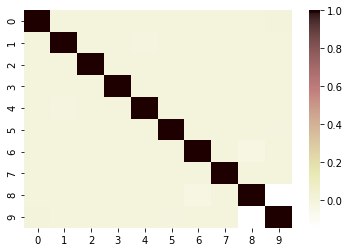

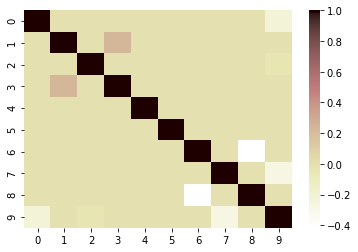

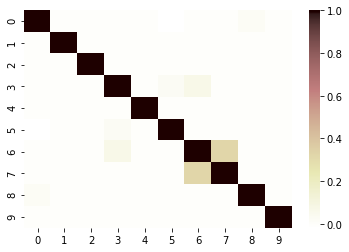

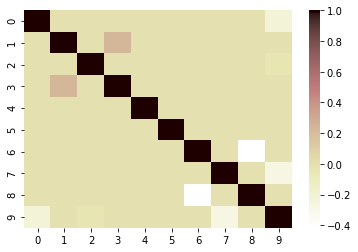

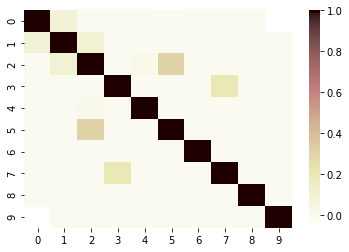

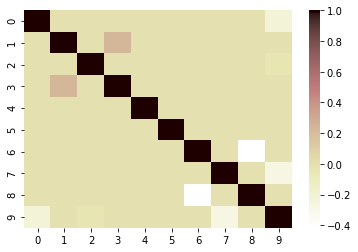

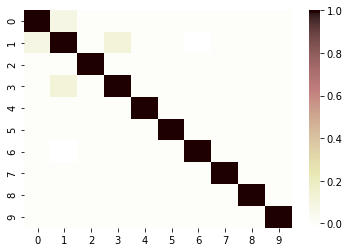

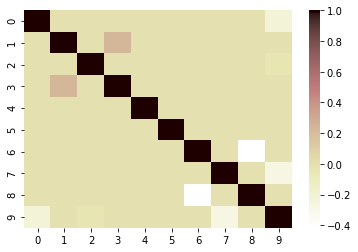

KeyboardInterrupt: 

In [13]:
Plot = True
glasso_predict(ps_model, test_data, True)